Epoch 1 train: : 312batch [00:03, 91.67batch/s, train_acc=0.157] 
Epoch 1 valid: : 78batch [00:00, 274.81batch/s, valid_acc=0.207] 
Epoch 2 train: : 312batch [00:03, 86.02batch/s, train_acc=0.239] 
Epoch 2 valid: : 78batch [00:00, 260.69batch/s, valid_acc=0.253] 
Epoch 3 train: : 312batch [00:03, 100.81batch/s, train_acc=0.269] 
Epoch 3 valid: : 78batch [00:00, 289.76batch/s, valid_acc=0.272]
Epoch 4 train: : 312batch [00:03, 100.50batch/s, train_acc=0.288]
Epoch 4 valid: : 78batch [00:00, 283.13batch/s, valid_acc=0.289] 
Epoch 5 train: : 312batch [00:03, 93.37batch/s, train_acc=0.303]  
Epoch 5 valid: : 78batch [00:00, 263.16batch/s, valid_acc=0.306]
Epoch 6 train: : 312batch [00:03, 93.44batch/s, train_acc=0.314] 
Epoch 6 valid: : 78batch [00:00, 279.63batch/s, valid_acc=0.317]
Epoch 7 train: : 312batch [00:03, 87.39batch/s, train_acc=0.327] 
Epoch 7 valid: : 78batch [00:00, 291.26batch/s, valid_acc=0.32] 
Epoch 8 train: : 312batch [00:03, 103.42batch/s, train_acc=0.334]
Epoch 8 vali

测试精度: 48.67%


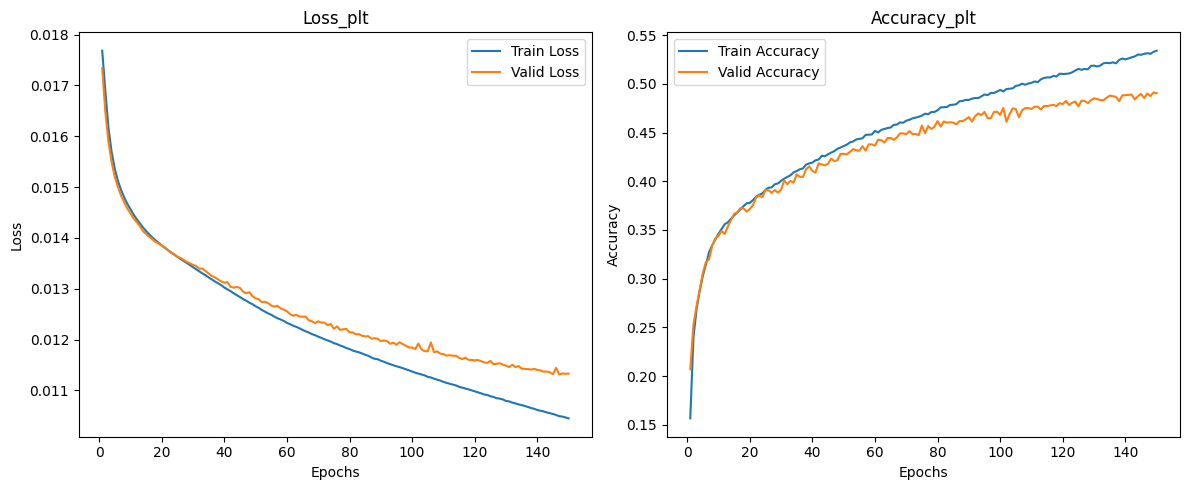

In [1]:
# SGD（no）+ crossEntrpy + bs128 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 128

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 72.22batch/s, train_acc=0.132] 
Epoch 1 valid: : 39batch [00:00, 178.03batch/s, valid_acc=0.188] 
Epoch 2 train: : 156batch [00:02, 76.64batch/s, train_acc=0.222]
Epoch 2 valid: : 39batch [00:00, 235.66batch/s, valid_acc=0.234]
Epoch 3 train: : 156batch [00:02, 71.55batch/s, train_acc=0.251]
Epoch 3 valid: : 39batch [00:00, 219.62batch/s, valid_acc=0.257]
Epoch 4 train: : 156batch [00:02, 71.65batch/s, train_acc=0.27] 
Epoch 4 valid: : 39batch [00:00, 223.03batch/s, valid_acc=0.282]
Epoch 5 train: : 156batch [00:02, 71.41batch/s, train_acc=0.29] 
Epoch 5 valid: : 39batch [00:00, 218.56batch/s, valid_acc=0.296]
Epoch 6 train: : 156batch [00:02, 70.49batch/s, train_acc=0.305]
Epoch 6 valid: : 39batch [00:00, 223.71batch/s, valid_acc=0.31] 
Epoch 7 train: : 156batch [00:02, 68.33batch/s, train_acc=0.315]
Epoch 7 valid: : 39batch [00:00, 221.93batch/s, valid_acc=0.317]
Epoch 8 train: : 156batch [00:02, 67.44batch/s, train_acc=0.326]
Epoch 8 valid: : 39batc

测试精度: 50.72%


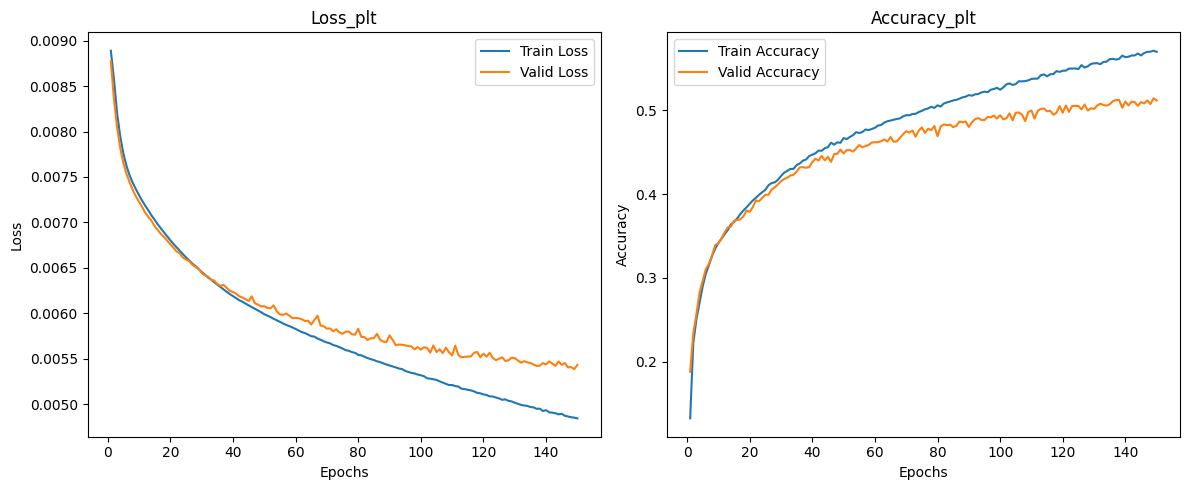

In [2]:
# SGD（no）+ crossEntrpy + bs256 + relu + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='relu')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 39batch [00:01, 24.61batch/s, train_acc=0.108] 
Epoch 1 valid: : 9batch [00:00, 67.74batch/s, valid_acc=0.0984]
Epoch 2 train: : 39batch [00:01, 24.69batch/s, train_acc=0.117] 
Epoch 2 valid: : 9batch [00:00, 69.00batch/s, valid_acc=0.132]
Epoch 3 train: : 39batch [00:01, 24.88batch/s, train_acc=0.156] 
Epoch 3 valid: : 9batch [00:00, 66.67batch/s, valid_acc=0.179]
Epoch 4 train: : 39batch [00:01, 23.81batch/s, train_acc=0.201] 
Epoch 4 valid: : 9batch [00:00, 66.93batch/s, valid_acc=0.2]  
Epoch 5 train: : 39batch [00:01, 24.26batch/s, train_acc=0.225] 
Epoch 5 valid: : 9batch [00:00, 69.81batch/s, valid_acc=0.211]
Epoch 6 train: : 39batch [00:01, 24.62batch/s, train_acc=0.238] 
Epoch 6 valid: : 9batch [00:00, 65.58batch/s, valid_acc=0.217]
Epoch 7 train: : 39batch [00:01, 24.33batch/s, train_acc=0.244] 
Epoch 7 valid: : 9batch [00:00, 67.60batch/s, valid_acc=0.232]
Epoch 8 train: : 39batch [00:01, 24.95batch/s, train_acc=0.254] 
Epoch 8 valid: : 9batch [00:00, 67.39b

测试精度: 38.43%


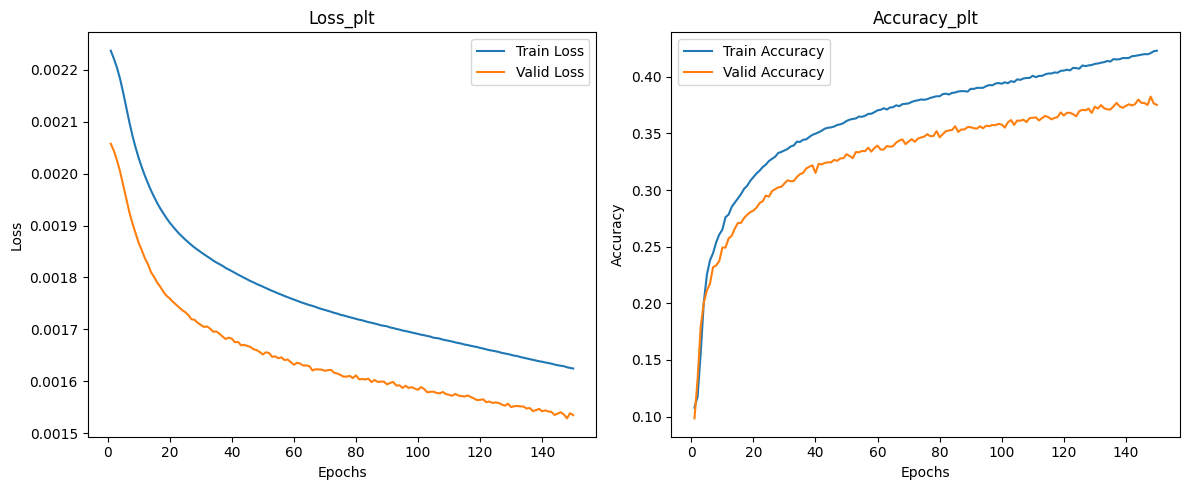

In [4]:
# SGD（no）+ crossEntrpy + bs1024 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 1024

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 78batch [00:01, 50.02batch/s, train_acc=0.123] 
Epoch 1 valid: : 19batch [00:00, 147.00batch/s, valid_acc=0.152]
Epoch 2 train: : 78batch [00:01, 49.42batch/s, train_acc=0.193] 
Epoch 2 valid: : 19batch [00:00, 148.99batch/s, valid_acc=0.212]
Epoch 3 train: : 78batch [00:01, 49.95batch/s, train_acc=0.234] 
Epoch 3 valid: : 19batch [00:00, 148.25batch/s, valid_acc=0.232]
Epoch 4 train: : 78batch [00:01, 45.50batch/s, train_acc=0.254] 
Epoch 4 valid: : 19batch [00:00, 124.99batch/s, valid_acc=0.247]
Epoch 5 train: : 78batch [00:01, 46.65batch/s, train_acc=0.267] 
Epoch 5 valid: : 19batch [00:00, 125.27batch/s, valid_acc=0.263]
Epoch 6 train: : 78batch [00:01, 45.61batch/s, train_acc=0.278] 
Epoch 6 valid: : 19batch [00:00, 124.75batch/s, valid_acc=0.271]
Epoch 7 train: : 78batch [00:01, 44.48batch/s, train_acc=0.285] 
Epoch 7 valid: : 19batch [00:00, 124.49batch/s, valid_acc=0.274]
Epoch 8 train: : 78batch [00:01, 40.90batch/s, train_acc=0.292] 
Epoch 8 valid: : 19batch 

测试精度: 44.49%


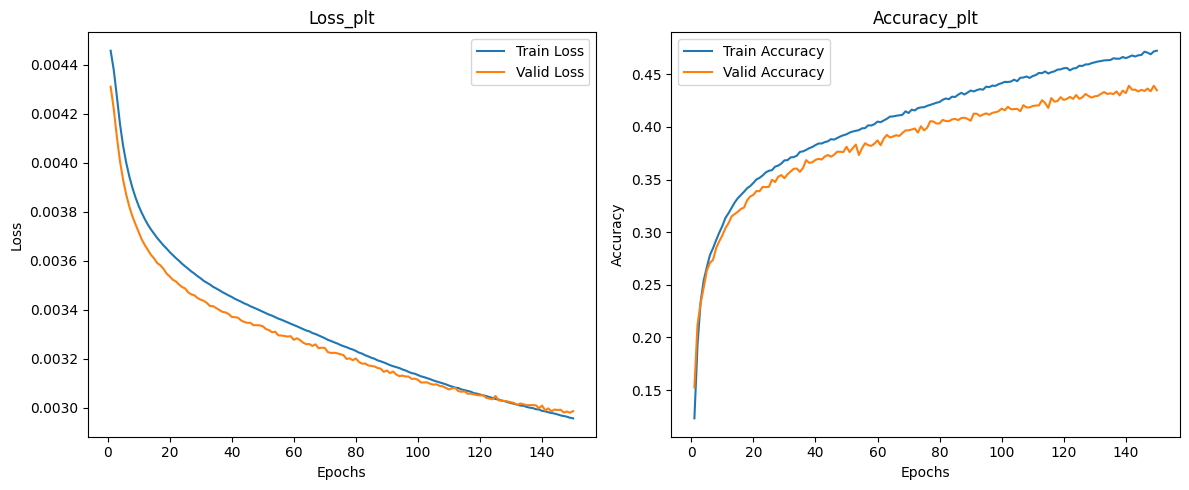

In [5]:
# SGD（no）+ crossEntrpy + bs512 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 512

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 70.72batch/s, train_acc=0.102] 
Epoch 1 valid: : 39batch [00:00, 228.40batch/s, valid_acc=0.103] 
Epoch 2 train: : 156batch [00:02, 76.31batch/s, train_acc=0.0995]
Epoch 2 valid: : 39batch [00:00, 227.94batch/s, valid_acc=0.103] 
Epoch 3 train: : 156batch [00:02, 76.27batch/s, train_acc=0.0997]
Epoch 3 valid: : 39batch [00:00, 214.68batch/s, valid_acc=0.103] 
Epoch 4 train: : 156batch [00:02, 73.05batch/s, train_acc=0.102] 
Epoch 4 valid: : 39batch [00:00, 227.56batch/s, valid_acc=0.108] 
Epoch 5 train: : 156batch [00:02, 72.67batch/s, train_acc=0.113] 
Epoch 5 valid: : 39batch [00:00, 210.02batch/s, valid_acc=0.139] 
Epoch 6 train: : 156batch [00:02, 73.98batch/s, train_acc=0.161]
Epoch 6 valid: : 39batch [00:00, 225.06batch/s, valid_acc=0.179]
Epoch 7 train: : 156batch [00:02, 76.85batch/s, train_acc=0.179]
Epoch 7 valid: : 39batch [00:00, 246.52batch/s, valid_acc=0.18] 
Epoch 8 train: : 156batch [00:02, 76.45batch/s, train_acc=0.183]
Epoch 8 valid: 

测试精度: 48.55%


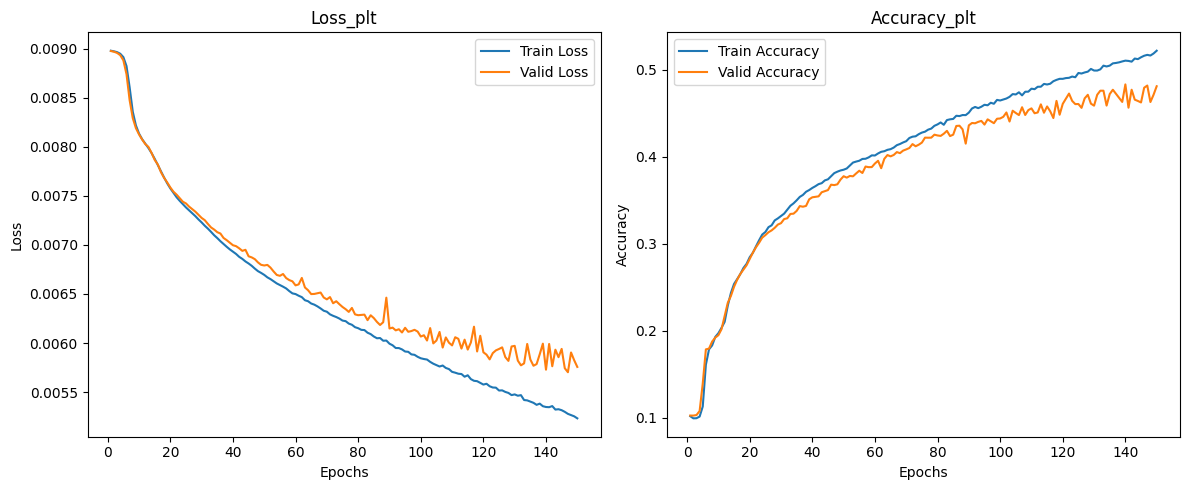

In [8]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.01 + 4层网络

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256, 128), activation='relu'):
        # 第一隐藏层
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        
        # 中间隐藏层，增加了一个新的隐藏层
        self.hidden_layer = LinearLayer(hidden_layer_sizes[0], hidden_layer_sizes[1], batch_size, activation, lr=lr)
        
        # 输出层（分类器）
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        
        # SoftMax层
        self.softmax = SoftMax()

        # 将层加入到层列表中
        self.layers = [self.input_layer, self.hidden_layer, self.classifier, self.softmax]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256, 128), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:03, 42.98batch/s, train_acc=0.106] 
Epoch 1 valid: : 39batch [00:00, 155.20batch/s, valid_acc=0.121] 
Epoch 2 train: : 156batch [00:03, 42.14batch/s, train_acc=0.139] 
Epoch 2 valid: : 39batch [00:00, 135.67batch/s, valid_acc=0.14]  
Epoch 3 train: : 156batch [00:03, 41.99batch/s, train_acc=0.141] 
Epoch 3 valid: : 39batch [00:00, 157.50batch/s, valid_acc=0.132] 
Epoch 4 train: : 156batch [00:03, 43.20batch/s, train_acc=0.127] 
Epoch 4 valid: : 39batch [00:00, 157.61batch/s, valid_acc=0.121] 
Epoch 5 train: : 156batch [00:04, 37.63batch/s, train_acc=0.121] 
Epoch 5 valid: : 39batch [00:00, 141.00batch/s, valid_acc=0.12]  
Epoch 6 train: : 156batch [00:04, 37.65batch/s, train_acc=0.12]  
Epoch 6 valid: : 39batch [00:00, 133.57batch/s, valid_acc=0.118] 
Epoch 7 train: : 156batch [00:04, 38.18batch/s, train_acc=0.12]  
Epoch 7 valid: : 39batch [00:00, 152.45batch/s, valid_acc=0.118] 
Epoch 8 train: : 156batch [00:03, 43.36batch/s, train_acc=0.124] 
Epoch 8 va

测试精度: 44.34%


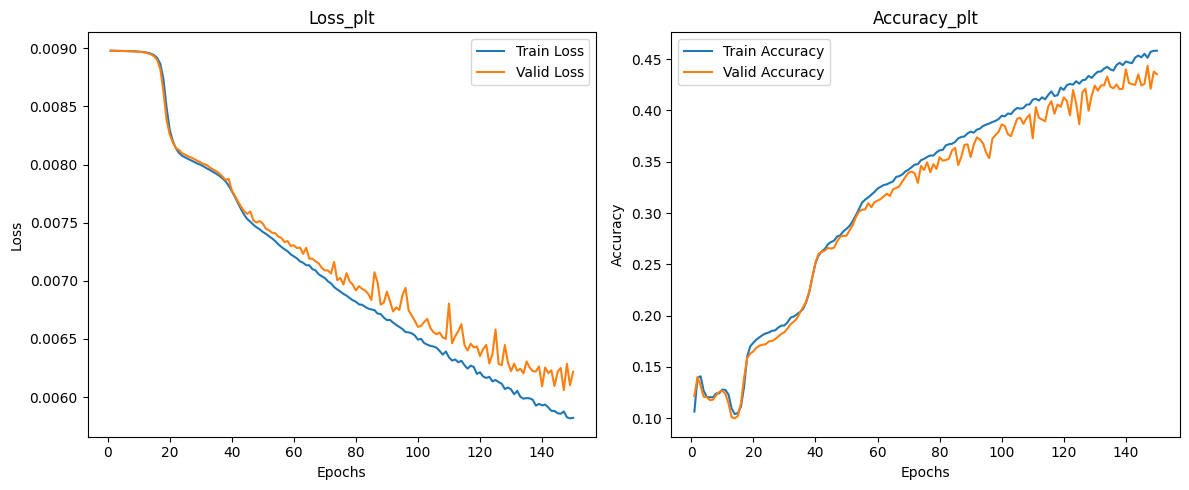

In [10]:
# SGD（no）+ crossEntrpy + bs256 + tanh + lr0.01 + 5层网络

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.batch_size = batch_size

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout
        self.W = self.W - self.dW * self.lr / self.batch_size
        self.b = self.b - self.db * self.lr / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(512, 256, 128), activation='relu'):
        # 第一隐藏层
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        
        # 中间隐藏层，增加了一个新的隐藏层
        self.hidden_layer = LinearLayer(hidden_layer_sizes[0], hidden_layer_sizes[1], batch_size, activation, lr=lr)
        
         # 中间隐藏层2，增加了一个新的隐藏层2
        self.hidden_layer_2 = LinearLayer(hidden_layer_sizes[1], hidden_layer_sizes[2], batch_size, activation, lr=lr)
        
        # 输出层（分类器）
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        
        # SoftMax层
        self.softmax = SoftMax()

        # 将层加入到层列表中
        self.layers = [self.input_layer, self.hidden_layer, self.hidden_layer_2, self.classifier, self.softmax]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(512, 256, 128), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:02, 58.17batch/s, train_acc=0.153] 
Epoch 1 valid: : 39batch [00:00, 221.12batch/s, valid_acc=0.182]
Epoch 2 train: : 156batch [00:02, 54.77batch/s, train_acc=0.233]
Epoch 2 valid: : 39batch [00:00, 198.76batch/s, valid_acc=0.27] 
Epoch 3 train: : 156batch [00:03, 45.78batch/s, train_acc=0.27] 
Epoch 3 valid: : 39batch [00:00, 201.93batch/s, valid_acc=0.281]
Epoch 4 train: : 156batch [00:02, 57.56batch/s, train_acc=0.29] 
Epoch 4 valid: : 39batch [00:00, 218.82batch/s, valid_acc=0.302]
Epoch 5 train: : 156batch [00:02, 58.08batch/s, train_acc=0.305]
Epoch 5 valid: : 39batch [00:00, 216.72batch/s, valid_acc=0.317]
Epoch 6 train: : 156batch [00:02, 62.76batch/s, train_acc=0.316]
Epoch 6 valid: : 39batch [00:00, 211.27batch/s, valid_acc=0.325]
Epoch 7 train: : 156batch [00:02, 58.49batch/s, train_acc=0.326]
Epoch 7 valid: : 39batch [00:00, 219.25batch/s, valid_acc=0.339]
Epoch 8 train: : 156batch [00:02, 58.89batch/s, train_acc=0.334]
Epoch 8 valid: : 39batch

测试精度: 49.12%


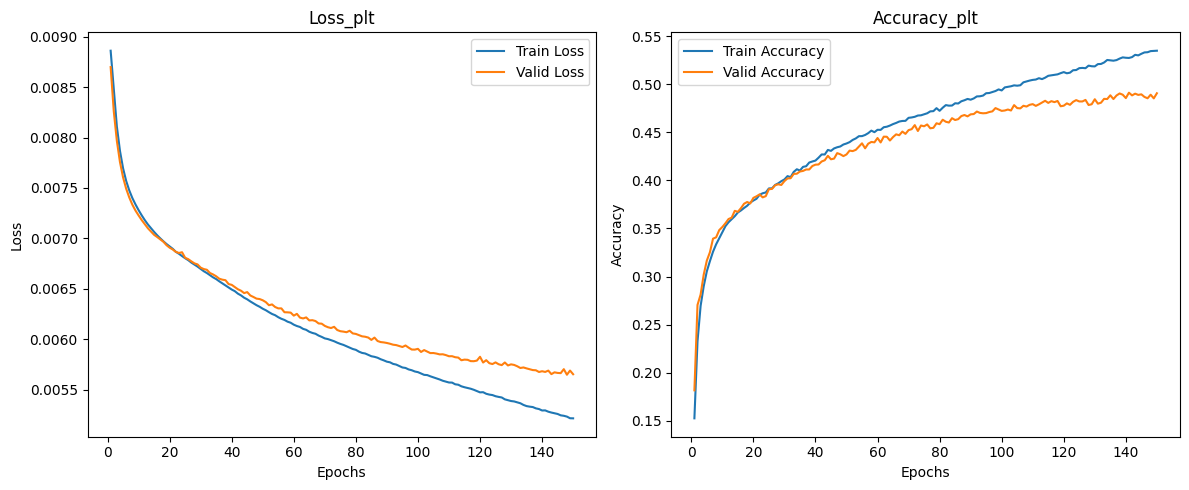

In [11]:
# SGD（0.9）+ crossEntrpy + bs256 + tanh + lr0.01

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001, momentum=0.9):
        self.W = np.random.normal(scale=0.01, size=(n_in, n_out))
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        
        # 初始化动量项为 0
        self.momentum = momentum
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout

        # 更新动量项
        self.vW = self.momentum * self.vW + (1 - self.momentum) * self.dW
        self.vb = self.momentum * self.vb + (1 - self.momentum) * self.db

        # 更新权重和偏置
        self.W = self.W - self.lr * self.vW / self.batch_size
        self.b = self.b - self.lr * self.vb / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout


# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu'):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.softmax = SoftMax()

        self.layers = [self.input_layer]
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.softmax)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 150
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='tanh')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))  # 交叉熵损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播
            outputs = model.forward(data)
            loss = np.mean(-np.sum(label * np.log(outputs + 1e-8), axis=1))
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            outputs = model.forward(data)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1 train: : 156batch [00:03, 42.65batch/s, train_acc=0.169] 
Epoch 1 valid: : 39batch [00:00, 228.74batch/s, valid_acc=0.193]
Epoch 2 train: : 156batch [00:03, 43.58batch/s, train_acc=0.189]
Epoch 2 valid: : 39batch [00:00, 210.08batch/s, valid_acc=0.215]
Epoch 3 train: : 156batch [00:03, 41.07batch/s, train_acc=0.206]
Epoch 3 valid: : 39batch [00:00, 213.08batch/s, valid_acc=0.218]
Epoch 4 train: : 156batch [00:04, 38.90batch/s, train_acc=0.214]
Epoch 4 valid: : 39batch [00:00, 154.83batch/s, valid_acc=0.237] 
Epoch 5 train: : 156batch [00:03, 39.68batch/s, train_acc=0.226]
Epoch 5 valid: : 39batch [00:00, 177.95batch/s, valid_acc=0.245]
Epoch 6 train: : 156batch [00:03, 42.19batch/s, train_acc=0.237]
Epoch 6 valid: : 39batch [00:00, 127.24batch/s, valid_acc=0.259] 
Epoch 7 train: : 156batch [00:03, 42.58batch/s, train_acc=0.242]
Epoch 7 valid: : 39batch [00:00, 215.39batch/s, valid_acc=0.273]
Epoch 8 train: : 156batch [00:03, 41.62batch/s, train_acc=0.252]
Epoch 8 valid: : 39bat

测试精度: 42.88%


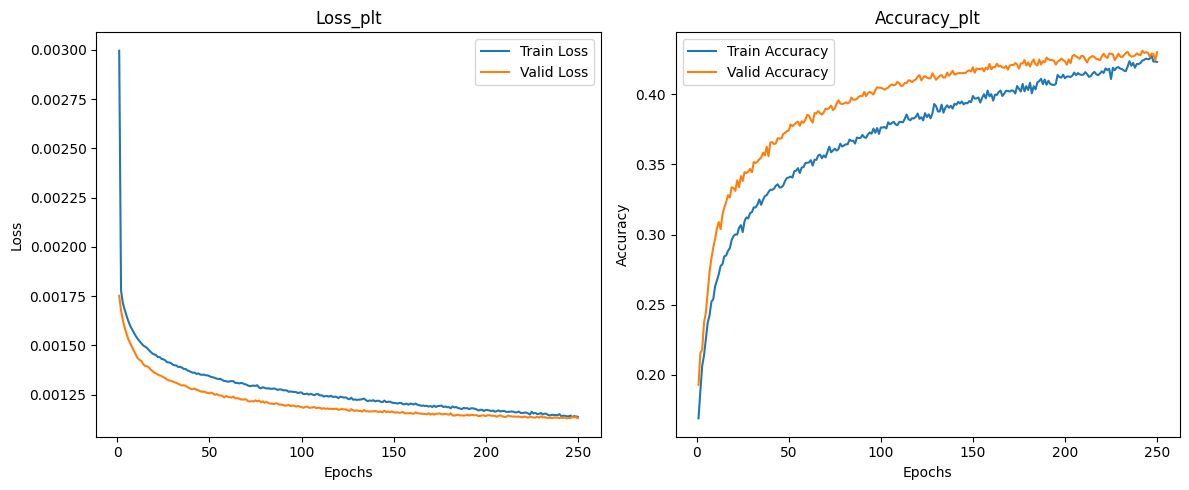

In [12]:
# SGD（0.9）+ fucal + bs256 + relu + lr0.01 + dropout0.15 + epoch250 + kaiming
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn.init as init
# 线性层
class LinearLayer:
    def __init__(self, n_in, n_out, batch_size, activation=None, lr=0.001, momentum=0.9):
        # 使用 torch 的张量初始化方式
        self.W = torch.empty((n_in, n_out), dtype=torch.float32)
        init.kaiming_normal_(self.W, nonlinearity='tanh')  # 使用Kaiming初始化
        
        self.b = np.zeros((batch_size, n_out))
        self.activation = activation
        self.lr = lr
        self.momentum = momentum
        self.batch_size = batch_size
        
        # 初始化动量项为 0
        self.vW = np.zeros_like(self.W)
        self.vb = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        output = np.dot(x, self.W) + self.b
        if self.activation == 'relu':
            output = np.maximum(0, output)
        elif self.activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif self.activation == 'tanh':
            output = np.tanh(output)
        self.activated_output = output
        return output

    def backward(self, dout):
        if self.activation == 'relu':
            dout = dout * (self.activated_output > 0)
        elif self.activation == 'sigmoid':
            dout = self.activated_output * (1 - self.activated_output) * dout
        elif self.activation == 'tanh':
            dout = (1 - self.activated_output ** 2) * dout
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = dout

        # 更新动量项
        self.vW = self.momentum * self.vW + (1 - self.momentum) * self.dW
        self.vb = self.momentum * self.vb + (1 - self.momentum) * self.db

        # 更新权重和偏置
        self.W -= torch.from_numpy(self.dW * self.lr / self.batch_size).float()  # 使用 torch 更新
        self.b = self.b - self.lr * self.vb / self.batch_size
        return dx

# SoftMax层
class SoftMax:
    def __init__(self):
        self.y_hat = None

    def forward(self, x):
        x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))  # 防止溢出
        partition = np.sum(x_exp, axis=1, keepdims=True)
        self.y_hat = x_exp / partition
        return self.y_hat

    def backward(self, y):
        dout = self.y_hat - y
        return dout

class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            # 在训练时生成一个mask，用于随机关闭神经元
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            # 在测试时，直接返回输入数据
            return x

    def backward(self, dout):
        # 反向传播时只传播未关闭神经元的梯度
        return dout * self.mask

# 多层感知机
class MLP:
    def __init__(self, input_size, batch_size, num_classes, lr=0.001, hidden_layer_sizes=(256,), activation='relu', dropout_rate=0.15):
        self.input_layer = LinearLayer(input_size, hidden_layer_sizes[0], batch_size, activation, lr=lr)
        self.dropout1 = Dropout(dropout_rate)  # 第一个 Dropout
        self.classifier = LinearLayer(hidden_layer_sizes[-1], num_classes, batch_size, None, lr=lr)
        self.dropout2 = Dropout(dropout_rate)  # 第二个 Dropout
        self.softmax = SoftMax()

        self.layers = [self.input_layer, self.dropout1]  # 加入 Dropout1
        for i in range(len(hidden_layer_sizes) - 1):
            self.layers.append(LinearLayer(hidden_layer_sizes[i], hidden_layer_sizes[i + 1], batch_size, activation, lr=lr))
        self.layers.append(self.classifier)
        self.layers.append(self.dropout2)  # 加入 Dropout2
        self.layers.append(self.softmax)

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)  # 在训练时使用 Dropout
            else:
                x = layer.forward(x)
        return x

    def backward(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
# Focal Loss实现
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # 加1e-8防止log(0)
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # 避免数值溢出问题
    
    # 计算交叉熵损失
    cross_entropy = -y_true * np.log(y_pred)
    
    # 计算 Focal Loss 的权重
    weight = alpha * np.power(1 - y_pred, gamma)
    
    # 计算最终的 Focal Loss
    focal_loss = weight * cross_entropy
    return np.mean(np.sum(focal_loss, axis=1))

# 下载并加载CIFAR-10数据
def load_cifar10_data(data_dir, valid_ratio=0.2):
    def load_batch(file):
        with open(file, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        labels = np.array(batch[b'labels'])
        return data, labels

    X_train, y_train = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        X_train.append(data)
        y_train.append(labels)

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    X_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))

    X_train = X_train.reshape(-1, 3, 32, 32).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 3, 32, 32).astype('float32') / 255.0

    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    # 将训练数据划分为训练集和验证集
    valid_size = int(X_train.shape[0] * valid_ratio)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train, X_valid = X_train[indices[:-valid_size]], X_train[indices[-valid_size:]]
    y_train, y_valid = y_train[indices[:-valid_size]], y_train[indices[-valid_size:]]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# 定义数据加载器
def dataloader(X, y, batch_size):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield X[excerpt], y[excerpt]

# 加载数据集
data_dir = 'Datasets/cifar-10-batches-py'
X_train, y_train, X_valid, y_valid, X_test, y_test = load_cifar10_data(data_dir)

# 展平输入数据
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 训练超参数
num_epochs = 250
batch_size = 256

# 初始化模型
model = MLP(input_size=3072, batch_size=batch_size, num_classes=10, lr=0.01, hidden_layer_sizes=(256,), activation='relu')

# 初始化列表以存储每个epoch的损失和准确率
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 训练模型
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = 0, 0
    with tqdm(dataloader(X_train, y_train, batch_size), unit='batch') as tepoch:
        for data, label in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1} train")

            # 前向传播（训练时启用 Dropout）
            outputs = model.forward(data, training=True)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            train_loss += loss
            train_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_train)

            # 反向传播
            model.backward(label)

            # 更新进度条中的准确率
            tepoch.set_postfix(train_acc=train_acc)

    train_losses.append(train_loss / len(X_train))
    train_accuracies.append(train_acc)

    # 验证阶段（禁用 Dropout）
    valid_loss, valid_acc = 0, 0
    with tqdm(dataloader(X_valid, y_valid, batch_size), unit='batch') as vepoch:
        for data, label in vepoch:
            vepoch.set_description(f"Epoch {epoch + 1} valid")

            # 前向传播（验证时禁用 Dropout）
            outputs = model.forward(data, training=False)
            loss = focal_loss(label, outputs, gamma=2.0, alpha=0.25)  # Focal 损失
            valid_loss += loss
            valid_acc += (outputs.argmax(1) == label.argmax(1)).sum() / len(X_valid)

            vepoch.set_postfix(valid_acc=valid_acc)

    valid_losses.append(valid_loss / len(X_valid))
    valid_accuracies.append(valid_acc)
    

# 测试阶段
def test_model(model, X_test, y_test):
    acc = 0
    with tqdm(range(0, len(X_test), batch_size), unit='batch') as tepoch:
        for i in tepoch:
            tepoch.set_description("Testing")
            data = X_test[i:i+batch_size]
            label = np.argmax(y_test[i:i+batch_size], axis=1)
            if data.shape[0] < batch_size:
                break
            # 测试时禁用 Dropout
            outputs = model.forward(data, training=False)
            acc += (outputs.argmax(1) == label).sum() / X_test.shape[0]
        tepoch.set_postfix(test_acc=acc)
    print(f'测试精度: {acc * 100:.2f}%')

# 调用测试函数
test_model(model, X_test, y_test)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()
